In [95]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

### Parameters

In [96]:
color = "#00BFFF"
figsize = (10, 5)

In [97]:
Enterprise_value = [400, 782, 1794, 3010, 4407, 6093]
Net_profit = [-27, 10, 39, 78, 180, 344] 
Revenue = [49, 107, 259, 461, 721, 1067]
investors_share =  0.3
dividend_share = 0.3
year_start = 2022
EBITDA = 40
number_of_users = 1000
churn_rate = 0.1
share_price = 20
dividend = 3
number_of_shares = 10000


Revenue_current = Revenue[0]
Net_profit_current = Net_profit[0]
Enterprise_value_current = Enterprise_value[0]
years = [year_start + i for i in range(len(Revenue))]


params_predict = [Enterprise_value, Net_profit, Revenue, investors_share, dividend_share, year_start]
params_current = [Revenue_current, EBITDA, Net_profit_current,  number_of_users, churn_rate,  share_price, dividend,  number_of_shares]

### Operational metrics

In [98]:
def compute_metrics(revenue, number_of_users, churn_rate):
    
    ARPU = round(revenue / number_of_users, 2)
    LT = round(1/churn_rate, 2) 
    LTV = round(ARPU * LT, 2)

    df = pd.DataFrame([ARPU, LT, LTV ]).T.rename(columns = {0: 'ARPU', 1: 'LT', 2: 'LTV'})
    
    return df

def compute_equity_multiples(revenue, net_profit, share_price, number_of_shares, dividends):

    earnings_per_share = net_profit/ number_of_shares
    div_per_share = round(dividends / number_of_shares, 2)
    revenue_per_share = revenue / number_of_shares

    p_e_ratio =  round(share_price / earnings_per_share, 2)
    div_yield =  round(div_per_share / share_price, 2)
    price_sales =  round(share_price / revenue_per_share, 2)

    df = pd.DataFrame([p_e_ratio,div_yield, price_sales]).T.rename(columns = {0: 'P/E Ratio', 1: 'Dividen Yield', 2: 'P/Sales'})
    return df


def compute_ev_multiples(EBITDA, revenue, Enterp_value):

    EV_EBITDA =  round(Enterp_value / EBITDA, 2)
    EV_Sales =  round(Enterp_value / revenue, 2)
    # EV_FCF =   round(Enterp_value / FCF, 2)

    df = pd.DataFrame([EV_EBITDA,EV_Sales]).T.rename(columns = {0: 'EV/EBITDA', 1: 'EV/Sales'})
    return df


In [99]:
user_metrics = compute_metrics(Revenue_current, number_of_users, churn_rate)
user_metrics

,ARPU,LT,LTV
0,0.05,10.0,0.5


In [100]:
equity_multiples_df = compute_equity_multiples(Revenue_current, Net_profit_current, share_price, number_of_shares, dividend)
equity_multiples_df


,P/E Ratio,Dividen Yield,P/Sales
0,-7407.41,0.0,4081.63


In [101]:
EV_multiples = compute_ev_multiples(EBITDA, Revenue_current, Enterprise_value_current)
EV_multiples


,EV/EBITDA,EV/Sales
0,10.0,8.16


In [102]:
def investors_indicators(EV_list, net_profit_list, inv_share, div_share, year_start = 2023):

    
    years_number = len(EV_list)
    years_columns = {i:year_start+i for i in range(years_number)}
    

    ev_growth = [round(100*(EV_list[i] / EV_list[i-1] - 1)) if EV_list[i - 1] != 0 else None  for i in range(1, years_number) ]
    attachments = round(EV_list[0]*inv_share)

    value_investors = [round(i*inv_share) for i in EV_list]
    growth_over_years = value_investors[-1] - value_investors[0]

    div_list = [max(0, round(div_share*net_profit_list[i])) for i in range(years_number)]
    total_profit = [value_investors[i] - attachments + sum(div_list[:i+1]) for i in range(1, years_number)]
    total_profit.insert(0, 0)
    profit_growth = [round(100*(total_profit[i] / total_profit[i-1] - 1)) if total_profit[i - 1] != 0 else None for i in range(1, years_number)]
    profit_growth.insert(0, None)

    ROI = round(100*total_profit[-1] / attachments)
    DPP = calculate_dpp(total_profit)

    EV = pd.DataFrame(EV_list)
    inv_share = pd.DataFrame([inv_share])
    ev_growth = pd.DataFrame(ev_growth)
    attachments = pd.DataFrame([attachments])
    value_investors = pd.DataFrame(value_investors)
    growth_over_years = pd.DataFrame([growth_over_years])
    div_list = pd.DataFrame(div_list)
    total_profit = pd.DataFrame(total_profit)
    profit_growth = pd.DataFrame(profit_growth)
    ROI = pd.DataFrame([ROI])
    DPP = pd.DataFrame([DPP])
    div_share = pd.DataFrame([div_share])

    output = pd.concat([EV, ev_growth, inv_share, attachments, value_investors, growth_over_years, div_share,\
                         div_list, total_profit, profit_growth, ROI, DPP], axis = 1).T.rename(columns = years_columns)

    output['Investor Indicators'] = ['EV', 'growth (%)',"Investor's share",'Attachments',
        "Value of the investor's share",'Growth over 5 years', 'For dividends',
        'Div', "Total investor's profit", "growth (%)", f'ROI for {years_number} years', 'DPP']
    
    output = output[[output.columns[-1]] + list(output.columns[:-1])].reset_index(drop = True)

    return output

def calculate_dpp(total_profit):
    for index, num in enumerate(total_profit):
        if num > 0:
            return index
    return f'More than {len(total_profit) + 1} years needed'



def cash_flows(total_profit, year_start = 2023):

    years_number = len(total_profit)
    years_columns = {i:year_start+i for i in range(years_number)}

    CFO = pd.DataFrame([np.abs(i) if i < 0 else None for i in total_profit ])
    FCF = pd.DataFrame([max(i, 0) for i in total_profit])

    cash_flows_output = pd.concat([CFO, FCF], axis = 1).T.rename(columns= years_columns)

    cash_flows_output['Cash Flow Statement Highlights, RUBmn'] = ['CFO', 'FCF']
    cash_flows_output = cash_flows_output[[cash_flows_output.columns[-1]] + list(cash_flows_output.columns[:-1])].reset_index(drop = True)

    return cash_flows_output


def income_statements_highlights(revenue_list, net_profit_list, year_start = 2023):

    first_per = None
    years_number = len(revenue_list)
    years_columns = {i:year_start+i for i in range(years_number)}

    revenue_growth = [round(100*(revenue_list[i]/revenue_list[i-1] - 1)) for i in range(1, years_number) ]
    net_profit_margin = [round(100*(net_profit_list[i]/revenue_list[i])) for i in range(years_number)]

    revenue_growth.insert(0, first_per)

    revenue = pd.DataFrame(revenue_list)
    revenue_growth = pd.DataFrame(revenue_growth)
    net_profit  = pd.DataFrame(net_profit_list)
    net_profit_margin = pd.DataFrame(net_profit_margin)

    income_statements_final = pd.concat([revenue, revenue_growth, net_profit, net_profit_margin], axis = 1).T.\
    rename(columns=years_columns)

    income_statements_final['Income Statement Highlights, RUBmn'] = ['Выручка', 'growth (%)', 'Чистая прибыль', 'margin (%)']
    income_statements_final = income_statements_final[[income_statements_final.columns[-1]] + list(income_statements_final.columns[:-1])].reset_index(drop = True)

    return income_statements_final


In [103]:
investors_indicators_df = investors_indicators(Enterprise_value, Net_profit, investors_share, dividend_share, year_start)
investors_indicators_df


,Investor Indicators,2022,2023,2024,2025,2026,2027
0,EV,400.0,782.0,1794.0,3010.0,4407.0,6093.0
1,growth (%),96.0,129.0,68.0,46.0,38.0,NaN
2,Investor's share,0.3,NaN,NaN,NaN,NaN,NaN
3,Attachments,120.0,NaN,NaN,NaN,NaN,NaN
4,Value of the investor's share,120.0,235.0,538.0,903.0,1322.0,1828.0
5,Growth over 5 years,1708.0,NaN,NaN,NaN,NaN,NaN
6,For dividends,0.3,NaN,NaN,NaN,NaN,NaN
7,Div,0.0,3.0,12.0,23.0,54.0,103.0
8,Total investor's profit,0.0,118.0,433.0,821.0,1294.0,1903.0
9,growth (%),NaN,NaN,267.0,90.0,58.0,47.0


In [104]:
cash_flows_df = cash_flows(Net_profit, year_start)
cash_flows_df


,"Cash Flow Statement Highlights, RUBmn",2022,2023,2024,2025,2026,2027
0,CFO,27.0,NaN,NaN,NaN,NaN,NaN
1,FCF,0.0,10.0,39.0,78.0,180.0,344.0


In [105]:
income_statements_highlights_df = income_statements_highlights(Revenue, Net_profit, year_start)
income_statements_highlights_df


,"Income Statement Highlights, RUBmn",2022,2023,2024,2025,2026,2027
0,Выручка,49.0,107.0,259.0,461.0,721.0,1067.0
1,growth (%),NaN,118.0,142.0,78.0,56.0,48.0
2,Чистая прибыль,-27.0,10.0,39.0,78.0,180.0,344.0
3,margin (%),-55.0,9.0,15.0,17.0,25.0,32.0


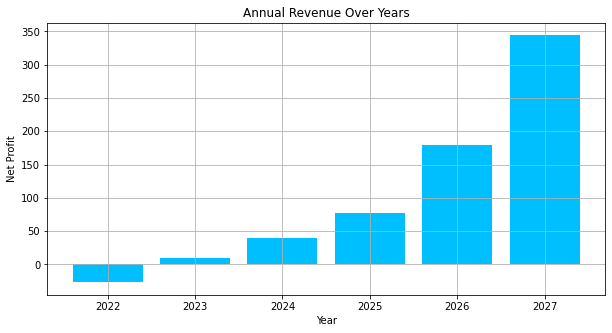

In [106]:
plt.figure(figsize= figsize)
plt.bar(years, Net_profit, color= color)
plt.title('Annual Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Net Profit')

# Set x-axis tick frequency to display every year
plt.xticks(years)

plt.grid(True)
plt.savefig('revenue.png')

plt.show()

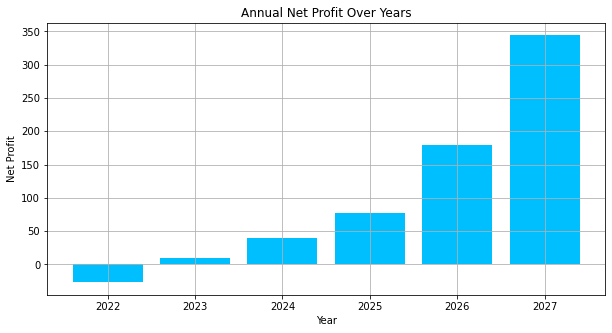

In [107]:
# Create a bar plot
plt.figure(figsize= figsize)
plt.bar(years, Net_profit, color= color)
plt.title('Annual Net Profit Over Years')
plt.xlabel('Year')
plt.ylabel('Net Profit')

# Set x-axis tick frequency to display every year
plt.xticks(years)

plt.grid(True)
plt.savefig('net_profit.png')

plt.show()


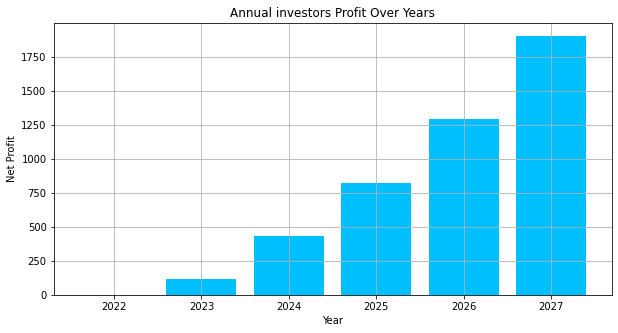

In [108]:
a = investors_indicators(Enterprise_value, Net_profit, investors_share, dividend_share, year_start = 2023)
investor_total_profit = a[a['Investor Indicators'] == "Total investor's profit"].values[0][1:]

plt.figure(figsize= figsize)
plt.bar(years, investor_total_profit, color= color)
plt.title('Annual investors Profit Over Years')
plt.xlabel('Year')
plt.ylabel('Net Profit')

# Set x-axis tick frequency to display every year
plt.xticks(years)

plt.grid(True)
plt.show()

### Save data

In [109]:
excel_writer = pd.ExcelWriter('output_file.xlsx', engine='xlsxwriter')

income_statements_highlights_df
cash_flows_df
investors_indicators_df
EV_multiples
equity_multiples_df
user_metrics
# Write each DataFrame to a separate sheet
income_statements_highlights_df.to_excel(excel_writer, sheet_name='income statements highlights', index=False)
cash_flows_df.to_excel(excel_writer, sheet_name='cash flows', index=False)
investors_indicators_df.to_excel(investors_indicators_df, sheet_name='investors indicators', index=False)
EV_multiples.to_excel(excel_writer, sheet_name='EV multiples', index=False)
equity_multiples_df.to_excel(excel_writer, sheet_name='Equity multiples', index=False)
user_metrics.to_excel(investors_indicators_df, sheet_name='User metrics', index=False)

# Save the Excel file
excel_writer.save()
